# Предложение 4

Наличные платежи становятся менее популярными. Необходимо обеспечить бесперебойную работу процессора для карт.

In [34]:
import os
from dotenv import load_dotenv
import json
import clickhouse_connect
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

In [20]:
# Read configuration
with open('./dags/conf/config.json', 'r') as f:
    CONFIG = json.load(f)

# Make a shortcut for database name
db = CONFIG['clickhouse']['dbs']['golden_db']
# TODO
CONFIG['clickhouse']['host'] = 'localhost'

# Get credentials
load_dotenv(dotenv_path='./dags/conf/.env', override=True)

try:
    # Get Clickhouse client
    ch_client = clickhouse_connect.get_client(
        host=CONFIG['clickhouse']['host'],
        port=CONFIG['clickhouse']['port'],
        username=os.getenv('CLICKHOUSE_USER'),
        password=os.getenv('CLICKHOUSE_PASS')
    )
except Exception as e:
    print(f"Error connecting to Clickhouse: {e}")


In [44]:
sql = f"""
    SELECT DATE_TRUNC('month', ft.pickup_datetime) AS year_month, SUM(pt.is_cash) as cash, SUM(pt.is_digital) as digital,
            SUM(pt.is_cash) / COUNT(pt.is_cash) AS cash_ratio,
            SUM(pt.is_digital) / COUNT(pt.is_digital) AS digital_ratio
        FROM {db}.fact_trip ft
        INNER JOIN {db}.dim_payment_type pt
            ON ft.payment_type = pt.payment_type_id
    GROUP BY year_month
    ORDER BY year_month
"""
# Get monthly distribution of payment types
try:
    payment_by_month = ch_client.query_df(sql)

except Exception as e:
    print(f'Error reading payment types by months: {e}')

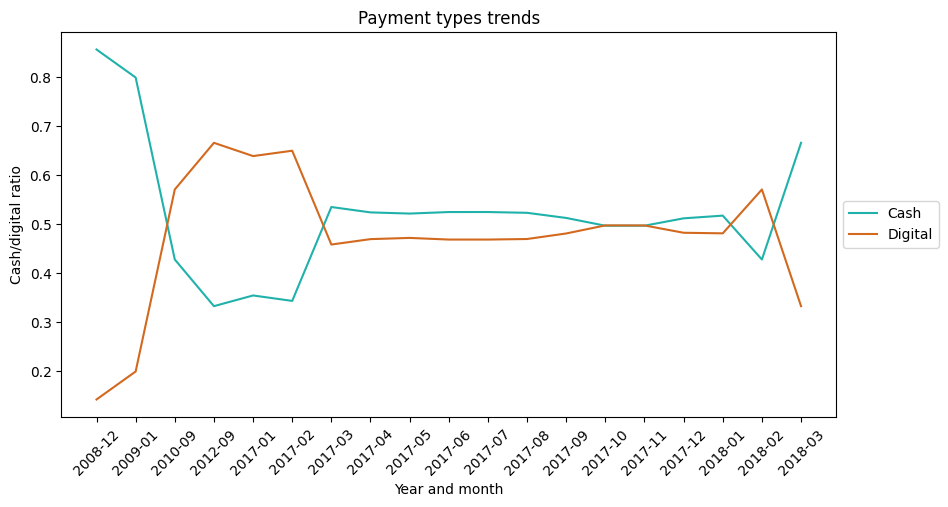

In [45]:
# Payment types distribution by month
plt.figure(figsize=(10,5))
plt.plot(payment_by_month['year_month'].astype(str).str[:-3], payment_by_month['cash_ratio'], color='lightseagreen', label='Cash')
plt.plot(payment_by_month['year_month'].astype(str).str[:-3], payment_by_month['digital_ratio'], color='chocolate', label='Digital')

plt.xlabel('Year and month')
plt.xticks(rotation=45)
plt.ylabel('Cash/digital ratio')
plt.title('Payment types trends')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [58]:
# Get future trend with simple moving aggregate for smoothing
# Set months count to forecast
forecast_period = 6
# Set rolling window, months
window = 3

# Calculate SMA
payment_by_month['digital_ratio_sma'] = payment_by_month['digital_ratio'].rolling(window=window).mean()

print(payment_by_month.head(20))



   year_month     cash  digital  cash_ratio  digital_ratio  cash_ratio_sma  \
0  2008-12-01        6        1    0.857143       0.142857             NaN   
1  2009-01-01       12        3    0.800000       0.200000             NaN   
2  2010-09-01        6        8    0.428571       0.571429        0.695238   
3  2012-09-01        1        2    0.333333       0.666667        0.520635   
4  2017-01-01  3230748  5818333    0.355161       0.639618        0.372355   
5  2017-02-01  2964485  5605267    0.344048       0.650528        0.344181   
6  2017-03-01   513798   440343    0.535657       0.459077        0.411622   
7  2017-04-01   473415   424187    0.524682       0.470123        0.468129   
8  2017-05-01   465308   421059    0.522282       0.472615        0.527540   
9  2017-06-01   430074   384091    0.525403       0.469227        0.524122   
10 2017-07-01   400673   357821    0.525429       0.469234        0.524371   
11 2017-08-01   376667   338225    0.523825       0.470364      

In [59]:
# Prepare data for linear regression
X = np.arange(len(payment_by_month)).reshape(-1, 1)
y = payment_by_month['digital_ratio_sma'].values

# Model linear regression
model = LinearRegression()
# Learn data avoiding first NaNs
model.fit(X[window-1:], y[window-1:])

future_X = np.arange(len(payment_by_month) + forecast_period).reshape(-1, 1)
forecast = model.predict(future_X)
print(forecast)


[0.51242204 0.51091382 0.50940559 0.50789737 0.50638915 0.50488093
 0.50337271 0.50186448 0.50035626 0.49884804 0.49733982 0.4958316
 0.49432337 0.49281515 0.49130693 0.48979871 0.48829049 0.48678226
 0.48527404 0.48376582 0.4822576  0.48074938 0.47924115 0.47773293
 0.47622471]


In [60]:
# Generate future dates
future_months = pd.date_range(payment_by_month['year_month'].iloc[-1] + pd.offsets.MonthBegin(), periods=forecast_period, freq='MS')
print(future_months)


DatetimeIndex(['2018-04-01', '2018-05-01', '2018-06-01', '2018-07-01',
               '2018-08-01', '2018-09-01'],
              dtype='datetime64[ns]', freq='MS')


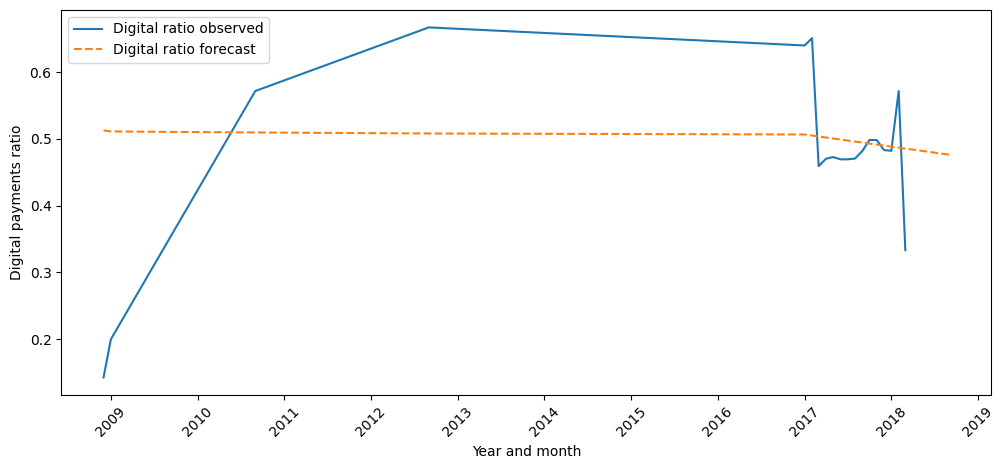

In [61]:
# Plot digital trend
plt.figure(figsize=(12,5))
plt.plot(payment_by_month['year_month'], payment_by_month['digital_ratio'], label='Digital ratio observed')
plt.plot(
    pd.concat([payment_by_month['year_month'], pd.Series(future_months)], ignore_index=True),
    forecast,
    '--',
    label='Digital ratio forecast'
)
plt.xlabel('Year and month')
plt.ylabel('Digital payments ratio')
plt.xticks(rotation=45)
plt.legend()
plt.show()